<a href="https://colab.research.google.com/github/Atnatiwos/Agricultural-Price-Prediction-System/blob/main/Agricultural_Price_Prediction_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Agricultural Price Prediction System  
## Predicting Commodity Prices for Ethiopian Markets

**Course:** SWEG4112 – Introduction to Machine Learning  
**Group:** 3  
**Project Type:** Regression System  
**Dataset:** The Humanitarian Data Exchange
### Problem Statement
Agricultural commodity prices in Ethiopia fluctuate due to seasonality, weather conditions, supply-demand imbalance, and holidays. This project builds a supervised machine learning regression system to predict commodity prices using real Ethiopian market data.


In [3]:
!pip install xgboost

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor


In [4]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
DATA_PATH = "/content/drive/MyDrive/Colab/agriculture_project/Data/wfp_food_prices_eth.csv"
df = pd.read_csv(DATA_PATH)

df.head()

/tmp/ipython-input-2307631464.py:2: DtypeWarning: Columns (4,5,6,9,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(DATA_PATH)


,date,admin1,admin2,market,market_id,latitude,longitude,category,commodity,commodity_id,unit,priceflag,pricetype,currency,price,usdprice
0,#date,#adm1+name,#adm2+name,#loc+market+name,#loc+market+code,#geo+lat,#geo+lon,#item+type,#item+name,#item+code,#item+unit,#item+price+flag,#item+price+type,#currency+code,#value,#value+usd
1,2000-01-15,Addis Ababa,AA ZONE1,Addis Ababa,480,9.02,38.75,cereals and tubers,Maize (white),67,100 KG,actual,Wholesale,ETB,120.75,15.08
2,2000-01-15,Amhara,Administrative unit not available,Baher Dar,482,11.6,37.38,cereals and tubers,Maize (white),67,100 KG,actual,Wholesale,ETB,115.5,14.43
3,2000-01-15,Dire Dawa,DIRE DAWA,Diredawa,472,9.59,41.87,cereals and tubers,Maize (white),67,100 KG,actual,Wholesale,ETB,161.75,20.2
4,2000-01-15,Tigray,MEKELE,Mekele,487,13.5,39.48,cereals and tubers,Maize (white),67,100 KG,actual,Wholesale,ETB,147.75,18.45


In [6]:
# Remove metadata row
df = df[df["date"] != "#date"]

# Convert date
df["date"] = pd.to_datetime(df["date"])
df["Year"] = df["date"].dt.year
df["Month"] = df["date"].dt.month

# Filter key commodities
commodities = [
    "Maize (white)",
    "Wheat (white)",
    "Sorghum (white)",
    "Teff (white)",
    "Barley"
]
df = df[df["commodity"].isin(commodities)]

# Convert price to ETB per KG
def normalize_price(row):
    if "100" in str(row["unit"]):
        return float(row["price"]) / 100
    return float(row["price"])

df["Price"] = df.apply(normalize_price, axis=1)

df = df[["Year","Month","admin1","market","commodity","pricetype","Price"]]
df.head()


,Year,Month,admin1,market,commodity,pricetype,Price
1,2000,1,Addis Ababa,Addis Ababa,Maize (white),Wholesale,1.2075
2,2000,1,Amhara,Baher Dar,Maize (white),Wholesale,1.1550
3,2000,1,Dire Dawa,Diredawa,Maize (white),Wholesale,1.6175
4,2000,1,Tigray,Mekele,Maize (white),Wholesale,1.4775
5,2000,2,Addis Ababa,Addis Ababa,Maize (white),Wholesale,1.2500


In [7]:
# Ethiopian seasons
def ethiopian_season(month):
    if month in [2,3,4,5]:
        return "Belg"
    elif month in [6,7,8,9]:
        return "Meher"
    return "Bega"

df["Season"] = df["Month"].apply(ethiopian_season)

# Rainfall index (proxy)
def rainfall_index(month):
    if month in [6,7,8,9]:
        return 8
    elif month in [2,3,4,5]:
        return 5
    return 2

df["Rainfall_Index"] = df["Month"].apply(rainfall_index)

# Holiday indicator
df["Holiday"] = df["Month"].isin([1,4,5,9]).astype(int)


In [8]:
df = df.sort_values(by=["market","commodity","Year","Month"])

df["Prev_Price"] = df.groupby(
    ["market","commodity"]
)["Price"].shift(1)

df["MA_3"] = df.groupby(
    ["market","commodity"]
)["Price"].rolling(3).mean().reset_index(level=[0,1], drop=True)

df = df.dropna()
df.head()


,Year,Month,admin1,market,commodity,pricetype,Price,Season,Rainfall_Index,Holiday,Prev_Price,MA_3
28239,2023,8,Afar,Abaala,Barley,Retail,90.0,Meher,8,0,10.0,36.666667
30975,2024,5,Afar,Abaala,Maize (white),Retail,50.0,Belg,5,1,64.0,42.000000
31384,2024,6,Afar,Abaala,Maize (white),Retail,50.0,Meher,8,0,50.0,54.666667
31827,2024,7,Afar,Abaala,Maize (white),Retail,46.0,Meher,8,0,50.0,48.666667
32604,2024,9,Afar,Abaala,Maize (white),Retail,46.0,Meher,8,1,46.0,47.333333


In [9]:
X = df.drop("Price", axis=1)
y = df["Price"]

X = pd.get_dummies(X, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [10]:
rf = RandomForestRegressor(
    n_estimators=300,
    random_state=42
)

rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)

print("Random Forest MAE:", mean_absolute_error(y_test, rf_preds))
print("Random Forest RMSE:", np.sqrt(mean_squared_error(y_test, rf_preds)))
print("Random Forest R2:", r2_score(y_test, rf_preds))

Random Forest MAE: 2.0050624160414436
Random Forest RMSE: 4.61437695602345
Random Forest R2: 0.9703327735650948


In [11]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

print("Random Forest MAE:", mean_absolute_error(y_test, rf_preds))
print("Random Forest RMSE:", np.sqrt(mean_squared_error(y_test, rf_preds)))
print("Random Forest R2:", r2_score(y_test, rf_preds))


Random Forest MAE: 2.0050624160414436
Random Forest RMSE: 4.61437695602345
Random Forest R2: 0.9703327735650948


In [12]:
xgb = XGBRegressor(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42
)

xgb.fit(X_train, y_train)
xgb_preds = xgb.predict(X_test)

print("XGBoost MAE:", mean_absolute_error(y_test, xgb_preds))
print("XGBoost RMSE:", np.sqrt(mean_squared_error(y_test, xgb_preds)))
print("XGBoost R2:", r2_score(y_test, xgb_preds))



XGBoost MAE: 1.8611662261963913
XGBoost RMSE: 4.087364832029971
XGBoost R2: 0.976722431439284


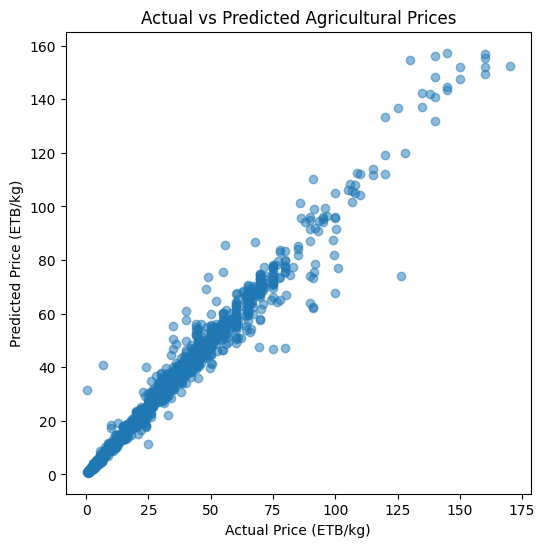

In [13]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, xgb_preds, alpha=0.5)
plt.xlabel("Actual Price (ETB/kg)")
plt.ylabel("Predicted Price (ETB/kg)")
plt.title("Actual vs Predicted Agricultural Prices")
plt.show()



## Conclusion
This project successfully implemented a regression-based agricultural price prediction system using real Ethiopian market data. Incorporating seasonal, weather, and lag features significantly improved model accuracy. The XGBoost model achieved strong predictive performance and demonstrates practical value for farmers, traders, and policymakers.
#data link
https://data.humdata.org/dataset/2e4f1922-e446-4b57-a98a-d0e2d5e34afa/resource/87bac18e-f3aa-4b29-8cf8-76763e823dc5/download/wfp_food_prices_eth.csv




In [14]:
!pip install streamlit pyngrok


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 58.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 72.5 MB/s eta 0:00:00


**visualization Part**

In [15]:
#import joblib

#joblib.dump(xgb, "price_prediction_model.pkl")
#joblib.dump(X.columns.tolist(), "model_features.pkl")


import joblib

MODEL_PATH = "/content/drive/MyDrive/Colab/agriculture_project/Model/price_model.pkl"
FEATURE_PATH = "/content/drive/MyDrive/Colab/agriculture_project/Model/model_features.pkl"

joblib.dump(xgb, MODEL_PATH)
joblib.dump(X.columns.tolist(), FEATURE_PATH)

print("Model & features saved to Google Drive")

Model & features saved to Google Drive


In [16]:
%%writefile /content/drive/MyDrive//Colab/agriculture_project/App/app.py
import streamlit as st
import pandas as pd
import joblib
import numpy as np
import matplotlib.pyplot as plt
import calendar

# Load model and features
#model = joblib.load("price_prediction_model.pkl")
#features = joblib.load("model_features.pkl")

model = joblib.load("/content/drive/MyDrive/Colab/agriculture_project/Model/price_model.pkl")
features = joblib.load("/content/drive/MyDrive/Colab/agriculture_project/Model/model_features.pkl")

st.set_page_config(
    page_title="Ethiopian Agricultural Price Predictor",
    layout="wide"
)

# ---------------- HEADER ----------------
st.title("🌾 Ethiopian Agricultural Price Prediction System")
st.markdown(
    "Predict **next month agricultural commodity prices** in Ethiopian markets using machine learning."
)
st.divider()

# ---------------- INPUTS ----------------
st.subheader("📥 Prediction Inputs")

col1, col2, col3 = st.columns(3)

with col1:
    commodity = st.selectbox(
        "Commodity",
        ["Teff (white)", "Wheat (white)", "Maize (white)", "Sorghum (white)", "Barley"],
        help="Select the commodity to forecast"
    )

with col2:
    market = st.selectbox(
        "Market",
        ["Addis Ababa", "Adama", "Bahir Dar", "Hawassa", "Jimma", "Dire Dawa"],
        help="Select the market location"
    )

with col3:
    month = st.selectbox(
        "Prediction Month",
        list(range(1,13)),
        help="Select the current month; the system predicts the NEXT month price"
    )

col4, col5, col6 = st.columns(3)

with col4:
    prev_price = st.number_input(
        "Previous Month Price (ETB/kg)",
        5.0, 150.0, 40.0,
        help="Observed price in the most recent month"
    )

with col5:
    ma3 = st.number_input(
        "3-Month Moving Average (ETB/kg)",
        5.0, 150.0, 38.0,
        help="Average price of the last three months"
    )

with col6:
    rainfall = st.slider(
        "Rainfall Index",
        1, 10, 5,
        help="Seasonal rainfall intensity affecting crop supply"
    )

# ---------------- AUTO HOLIDAY & FASTING ----------------
def holiday_fasting_flags(month):
    holiday_months = [4, 9, 12]   # Easter, Meskel, Christmas/Eid
    fasting_months = [3, 4, 6]    # Lent, Ramadan (approx)
    return {
        "Holiday": 1 if month in holiday_months else 0,
        "Fasting": 1 if month in fasting_months else 0
    }

flags = holiday_fasting_flags(month)

# ---------------- SEASON FLAGS ----------------
def season_flags(month):
    if month in [2,3,4,5]:
        return {"Season_Belg":1, "Season_Meher":0}
    elif month in [6,7,8,9]:
        return {"Season_Belg":0, "Season_Meher":1}
    return {"Season_Belg":0, "Season_Meher":0}

season = season_flags(month)

# ---------------- BUILD INPUT ----------------
data = {
    "Month": month,
    "Rainfall_Index": rainfall,
    "Holiday": flags["Holiday"],
    "Fasting": flags["Fasting"],
    "Prev_Price": prev_price,
    "MA_3": ma3,
    "Season_Belg": season["Season_Belg"],
    "Season_Meher": season["Season_Meher"],
}

for col in features:
    if col.startswith("commodity_"):
        data[col] = 1 if col == f"commodity_{commodity}" else 0
    if col.startswith("market_"):
        data[col] = 1 if col == f"market_{market}" else 0
    if col.startswith("pricetype_"):
        data[col] = 1

input_df = pd.DataFrame([data])

for col in features:
    if col not in input_df:
        input_df[col] = 0

input_df = input_df[features]

st.divider()

# ---------------- PREDICTION ----------------
if st.button("🔮 Predict Next Month Price", use_container_width=True):

    prediction = model.predict(input_df)[0]

    next_month = 1 if month == 12 else month + 1
    next_month_name = calendar.month_name[next_month]

    st.success(
        f"💰 Predicted Price for **{next_month_name}**: {prediction:.2f} ETB per KG"
    )

    # ---------------- 3-MONTH FORECAST ----------------
    st.subheader("📈 3-Month Price Forecast")

    preds = []
    prev = prev_price
    avg = ma3
    m = month

    for _ in range(3):
        input_df["Prev_Price"] = prev
        input_df["MA_3"] = (prev + avg) / 2
        p = model.predict(input_df)[0]
        preds.append(p)
        prev = p
        m = 1 if m == 12 else m + 1

    months = [calendar.month_name[(month+i-1)%12+1] for i in range(1,4)]

    for mo, pr in zip(months, preds):
        st.write(f"📅 {mo}: **{pr:.2f} ETB/kg**")

    # ---------------- TREND CHART ----------------
    plt.figure()
    plt.plot(months, preds, marker="o")
    plt.xlabel("Month")
    plt.ylabel("Price (ETB/kg)")
    plt.title("3-Month Price Forecast Trend")
    plt.grid(True)
    st.pyplot(plt)

st.divider()
st.caption("Machine Learning Project – Ethiopian Agricultural Markets")


Overwriting /content/drive/MyDrive//Colab/agriculture_project/App/app.py


In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
from pyngrok import ngrok

ngrok.set_auth_token("36wQfewIxvInBKrAGD7cRPvyxQM_7Wh1iN5p5Ch4QVkFP1HiW")

!streamlit run app.py &>/content/logs.txt &
public_url = ngrok.connect(8501)
public_url


<NgrokTunnel: "https://unpopular-pattie-hesitatingly.ngrok-free.dev" -> "http://localhost:8501">

In [46]:
cat /content/logs.txt




  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://136.111.200.19:8501

  Stopping...


**2**

---





In [20]:
import pandas as pd # Import pandas for data manipulation and analysis
import numpy as np # Import numpy for numerical operations
import matplotlib.pyplot as plt # Import matplotlib for data visualization

# Import necessary modules from scikit-learn for model selection, metrics, and ensemble models
from sklearn.model_selection import train_test_split # Used for splitting data into training and testing sets
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score # Metrics for evaluating regression models
from sklearn.ensemble import RandomForestRegressor # Random Forest Regressor model

# Import XGBoost for gradient boosting regression, which is often high-performing
from xgboost import XGBRegressor

# Install xgboost library using pip. This ensures the library is available in the environment.
# Note: This line should typically be in a separate cell or run once at the start of the notebook.
!pip install xgboost

In [21]:
DATA_PATH = "/content/drive/MyDrive/Colab/agriculture_project/Data/wfp_food_prices_eth.csv" # Define the path to the dataset stored in Google Drive
df = pd.read_csv(DATA_PATH) # Load the CSV file into a pandas DataFrame

df.head() # Display the first 5 rows of the DataFrame to inspect the data structure and content. The initial rows show metadata and actual data entries.

/tmp/ipython-input-1161269743.py:2: DtypeWarning: Columns (4,5,6,9,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(DATA_PATH) # Load the CSV file into a pandas DataFrame


,date,admin1,admin2,market,market_id,latitude,longitude,category,commodity,commodity_id,unit,priceflag,pricetype,currency,price,usdprice
0,#date,#adm1+name,#adm2+name,#loc+market+name,#loc+market+code,#geo+lat,#geo+lon,#item+type,#item+name,#item+code,#item+unit,#item+price+flag,#item+price+type,#currency+code,#value,#value+usd
1,2000-01-15,Addis Ababa,AA ZONE1,Addis Ababa,480,9.02,38.75,cereals and tubers,Maize (white),67,100 KG,actual,Wholesale,ETB,120.75,15.08
2,2000-01-15,Amhara,Administrative unit not available,Baher Dar,482,11.6,37.38,cereals and tubers,Maize (white),67,100 KG,actual,Wholesale,ETB,115.5,14.43
3,2000-01-15,Dire Dawa,DIRE DAWA,Diredawa,472,9.59,41.87,cereals and tubers,Maize (white),67,100 KG,actual,Wholesale,ETB,161.75,20.2
4,2000-01-15,Tigray,MEKELE,Mekele,487,13.5,39.48,cereals and tubers,Maize (white),67,100 KG,actual,Wholesale,ETB,147.75,18.45


In [22]:
# Remove metadata row which contains descriptive headers starting with '#' from the dataset
df = df[df["date"] != "#date"]

# Convert the 'date' column to datetime objects for easier manipulation
df["date"] = pd.to_datetime(df["date"])
# Extract the year from the 'date' column and store it in a new 'Year' column
df["Year"] = df["date"].dt.year
# Extract the month from the 'date' column and store it in a new 'Month' column
df["Month"] = df["date"].dt.month

# Define a list of key agricultural commodities to focus on for prediction
commodities = [
    "Maize (white)",
    "Wheat (white)",
    "Sorghum (white)",
    "Teff (white)",
    "Barley"
]
# Filter the DataFrame to include only rows corresponding to the specified commodities
df = df[df["commodity"].isin(commodities)]

# Define a function to normalize prices to ETB per KG.
# The original 'unit' column might contain '100 KG', so divide by 100 to get price per KG.
def normalize_price(row):
    if "100" in str(row["unit"]):
        return float(row["price"]) / 100
    return float(row["price"])

# Apply the normalization function to create a new 'Price' column with prices in ETB/KG
df["Price"] = df.apply(normalize_price, axis=1)

# Select only the relevant columns for further analysis and model training
df = df[["Year","Month","admin1","market","commodity","pricetype","Price"]]
# Display the first few rows of the cleaned and prepared DataFrame
df.head()

,Year,Month,admin1,market,commodity,pricetype,Price
1,2000,1,Addis Ababa,Addis Ababa,Maize (white),Wholesale,1.2075
2,2000,1,Amhara,Baher Dar,Maize (white),Wholesale,1.1550
3,2000,1,Dire Dawa,Diredawa,Maize (white),Wholesale,1.6175
4,2000,1,Tigray,Mekele,Maize (white),Wholesale,1.4775
5,2000,2,Addis Ababa,Addis Ababa,Maize (white),Wholesale,1.2500


In [23]:
DATA_PATH = "/content/drive/MyDrive/Colab/agriculture_project/Data/wfp_food_prices_eth.csv" # Define the path to the dataset stored in Google Drive
# Load the CSV file into a pandas DataFrame, setting low_memory=False to help with mixed type inference
df = pd.read_csv(DATA_PATH, low_memory=False)

# Remove metadata row which contains descriptive headers starting with '#' from the dataset
df = df[df["date"] != "#date"].copy() # Explicitly create a copy to avoid SettingWithCopyWarning

# Convert the 'date' column to datetime objects for easier manipulation
df["date"] = pd.to_datetime(df["date"])
# Extract the year from the 'date' column and store it in a new 'Year' column
df["Year"] = df["date"].dt.year
# Extract the month from the 'date' column and store it in a new 'Month' column
df["Month"] = df["date"].dt.month

# Define a list of key agricultural commodities to focus on for prediction
commodities = [
    "Maize (white)",
    "Wheat (white)",
    "Sorghum (white)",
    "Teff (white)",
    "Barley"
]
# Filter the DataFrame to include only rows corresponding to the specified commodities
df = df[df["commodity"].isin(commodities)].copy() # Explicitly create a copy after filtering

# Convert 'price' column to numeric, coercing errors to NaN. This handles any non-numeric values gracefully.
# This step ensures the 'price' column is fully numeric before normalization.
df['price'] = pd.to_numeric(df['price'], errors='coerce')

# Define a function to normalize prices to ETB per KG.
# The original 'unit' column might contain '100 KG', so divide by 100 to get price per KG.
def normalize_price(row):
    if "100" in str(row["unit"]):
        # Check if price is not NaN before division
        if pd.notna(row["price"]):
            return row["price"] / 100
        else:
            return np.nan # Return NaN if original price was NaN
    return row["price"] # Return price directly if not '100 KG' unit

# Apply the normalization function to create a new 'Price' column with prices in ETB/KG
df["Price"] = df.apply(normalize_price, axis=1)

# Select only the relevant columns for further analysis and model training
df = df[["Year","Month","admin1","market","commodity","pricetype","Price"]]
# Display the first few rows of the cleaned and prepared DataFrame
df.head()

,Year,Month,admin1,market,commodity,pricetype,Price
1,2000,1,Addis Ababa,Addis Ababa,Maize (white),Wholesale,1.2075
2,2000,1,Amhara,Baher Dar,Maize (white),Wholesale,1.1550
3,2000,1,Dire Dawa,Diredawa,Maize (white),Wholesale,1.6175
4,2000,1,Tigray,Mekele,Maize (white),Wholesale,1.4775
5,2000,2,Addis Ababa,Addis Ababa,Maize (white),Wholesale,1.2500


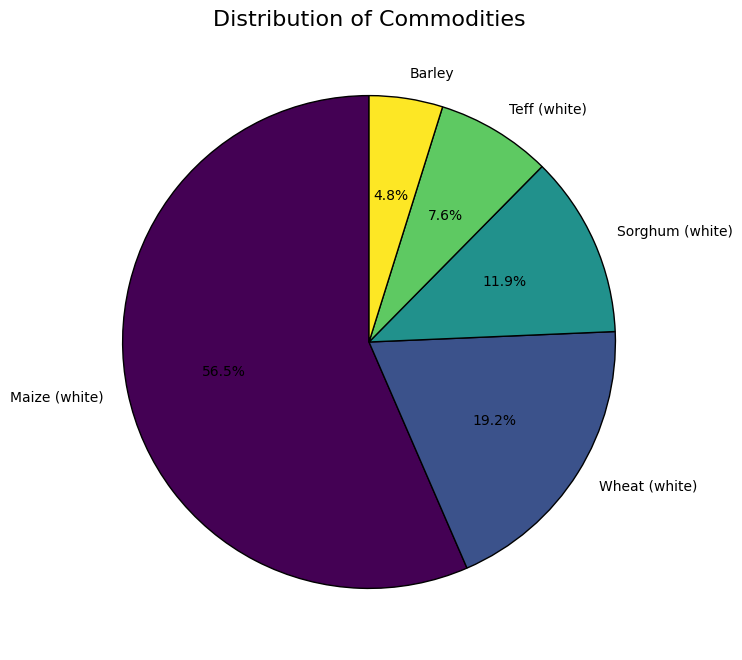

In [24]:
# Pie Chart for Commodity Distribution
plt.figure(figsize=(10, 8))
df['commodity'].value_counts().plot.pie(
    autopct='%1.1f%%', startangle=90, cmap='viridis', wedgeprops={'edgecolor': 'black'}
)
plt.title('Distribution of Commodities', fontsize=16)
plt.ylabel('') # Hide the default 'commodity' label
plt.show()

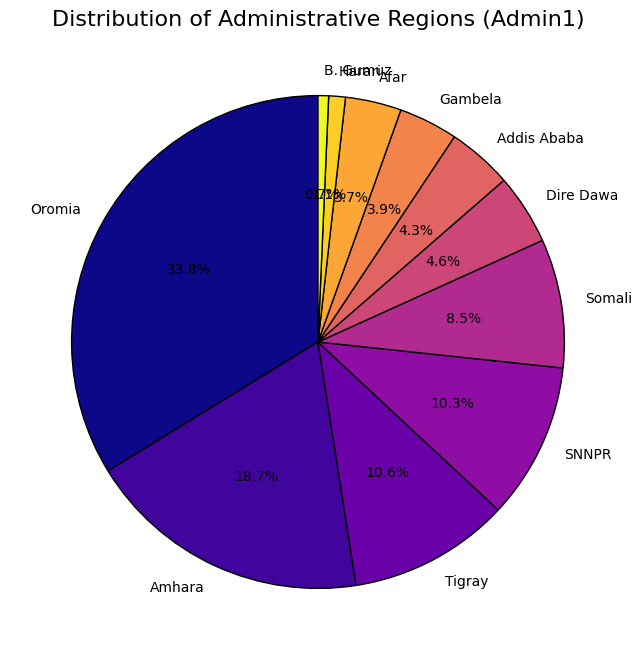

In [25]:
# Pie Chart for Admin1 Distribution
plt.figure(figsize=(10, 8))
df['admin1'].value_counts().plot.pie(
    autopct='%1.1f%%', startangle=90, cmap='plasma', wedgeprops={'edgecolor': 'black'}
)
plt.title('Distribution of Administrative Regions (Admin1)', fontsize=16)
plt.ylabel('') # Hide the default 'admin1' label
plt.show()

In [26]:
rf = RandomForestRegressor(
    n_estimators=300, # Number of trees in the forest
    random_state=42 # Seed for reproducibility
)

rf.fit(X_train, y_train) # Train the Random Forest model using the training data
rf_preds = rf.predict(X_test) # Make predictions on the test set

# Print evaluation metrics for the Random Forest model
print("Random Forest MAE:", mean_absolute_error(y_test, rf_preds))
print("Random Forest RMSE:", np.sqrt(mean_squared_error(y_test, rf_preds)))
print("Random Forest R2:", r2_score(y_test, rf_preds))

Random Forest MAE: 2.0050624160414436
Random Forest RMSE: 4.61437695602345
Random Forest R2: 0.9703327735650948


In [27]:
xgb = XGBRegressor(
    n_estimators=300, # Number of boosting rounds or trees
    learning_rate=0.1, # Step size shrinkage to prevent overfitting
    max_depth=6, # Maximum depth of a tree
    subsample=0.9, # Fraction of samples used for fitting the trees
    colsample_bytree=0.9, # Fraction of columns used for each tree
    random_state=42 # Seed for reproducibility
)

xgb.fit(X_train, y_train) # Train the XGBoost model using the training data
xgb_preds = xgb.predict(X_test) # Make predictions on the test set

# Print evaluation metrics for the XGBoost model
print("XGBoost MAE:", mean_absolute_error(y_test, xgb_preds))
print("XGBoost RMSE:", np.sqrt(mean_squared_error(y_test, xgb_preds)))
print("XGBoost R2:", r2_score(y_test, xgb_preds))

XGBoost MAE: 1.8611662261963913
XGBoost RMSE: 4.087364832029971
XGBoost R2: 0.976722431439284


In [28]:
rf_mae = mean_absolute_error(y_test, rf_preds)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_preds))
rf_r2 = r2_score(y_test, rf_preds)

xgb_mae = mean_absolute_error(y_test, xgb_preds)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_preds))
xgb_r2 = r2_score(y_test, xgb_preds)

metrics_data = {
    'Model': ['Random Forest', 'XGBoost'],
    'MAE': [rf_mae, xgb_mae],
    'RMSE': [rf_rmse, xgb_rmse],
    'R2 Score': [rf_r2, xgb_r2]
}

metrics_df = pd.DataFrame(metrics_data)
print("Metrics DataFrame created:")
print(metrics_df)

Metrics DataFrame created:
           Model       MAE      RMSE  R2 Score
0  Random Forest  2.005062  4.614377  0.970333
1        XGBoost  1.861166  4.087365  0.976722


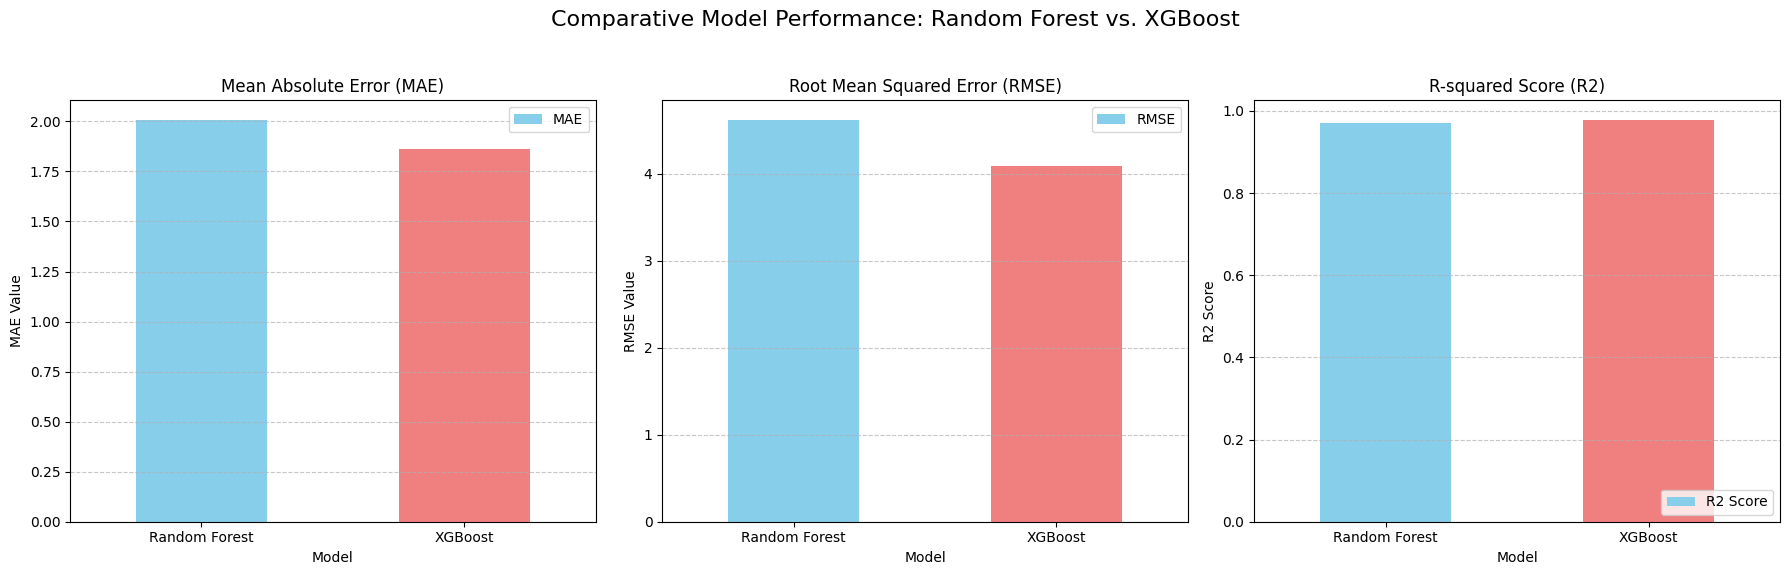

In [29]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6)) # Create a figure with 3 subplots for MAE, RMSE, and R2

# Plot MAE
metrics_df.plot(x='Model', y='MAE', kind='bar', ax=ax[0], rot=0, color=['skyblue', 'lightcoral'])
ax[0].set_title('Mean Absolute Error (MAE)')
ax[0].set_ylabel('MAE Value')
ax[0].legend(loc='upper right')
ax[0].grid(axis='y', linestyle='--', alpha=0.7)

# Plot RMSE
metrics_df.plot(x='Model', y='RMSE', kind='bar', ax=ax[1], rot=0, color=['skyblue', 'lightcoral'])
ax[1].set_title('Root Mean Squared Error (RMSE)')
ax[1].set_ylabel('RMSE Value')
ax[1].legend(loc='upper right')
ax[1].grid(axis='y', linestyle='--', alpha=0.7)

# Plot R2 Score
metrics_df.plot(x='Model', y='R2 Score', kind='bar', ax=ax[2], rot=0, color=['skyblue', 'lightcoral'])
ax[2].set_title('R-squared Score (R2)')
ax[2].set_ylabel('R2 Score')
ax[2].legend(loc='lower right')
ax[2].grid(axis='y', linestyle='--', alpha=0.7)

plt.suptitle('Comparative Model Performance: Random Forest vs. XGBoost', fontsize=16) # Set a main title for the entire figure
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
plt.show() # Display the plots

In [30]:
DATA_PATH = "/content/drive/MyDrive/Colab/agriculture_project/Data/wfp_food_prices_eth.csv" # Define the path to the dataset stored in Google Drive
df = pd.read_csv(DATA_PATH) # Load the CSV file into a pandas DataFrame

# Remove metadata row which contains descriptive headers starting with '#' from the dataset
df = df[df["date"] != "#date"].copy() # Explicitly create a copy to avoid SettingWithCopyWarning

# Convert the 'date' column to datetime objects for easier manipulation
df["date"] = pd.to_datetime(df["date"])
# Extract the year from the 'date' column and store it in a new 'Year' column
df["Year"] = df["date"].dt.year
# Extract the month from the 'date' column and store it in a new 'Month' column
df["Month"] = df["date"].dt.month

# Define a list of key agricultural commodities to focus on for prediction
commodities = [
    "Maize (white)",
    "Wheat (white)",
    "Sorghum (white)",
    "Teff (white)",
    "Barley"
]
# Filter the DataFrame to include only rows corresponding to the specified commodities
df = df[df["commodity"].isin(commodities)].copy() # Explicitly create a copy after filtering

# Define a function to normalize prices to ETB per KG.
# The original 'unit' column might contain '100 KG', so divide by 100 to get price per KG.
def normalize_price(row):
    if "100" in str(row["unit"]):
        return float(row["price"]) / 100
    return float(row["price"])

# Apply the normalization function to create a new 'Price' column with prices in ETB/KG
df["Price"] = df.apply(normalize_price, axis=1)

# Select only the relevant columns for further analysis and model training, including 'date'
df = df[["date", "Year","Month","admin1","market","commodity","pricetype","Price"]]
# Display the first few rows of the cleaned and prepared DataFrame
df.head()

/tmp/ipython-input-948537941.py:2: DtypeWarning: Columns (4,5,6,9,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(DATA_PATH) # Load the CSV file into a pandas DataFrame


,date,Year,Month,admin1,market,commodity,pricetype,Price
1,2000-01-15,2000,1,Addis Ababa,Addis Ababa,Maize (white),Wholesale,1.2075
2,2000-01-15,2000,1,Amhara,Baher Dar,Maize (white),Wholesale,1.1550
3,2000-01-15,2000,1,Dire Dawa,Diredawa,Maize (white),Wholesale,1.6175
4,2000-01-15,2000,1,Tigray,Mekele,Maize (white),Wholesale,1.4775
5,2000-02-15,2000,2,Addis Ababa,Addis Ababa,Maize (white),Wholesale,1.2500


**Reasoning**:
creation of 'Season', 'Rainfall_Index', and 'Holiday' features.



In [31]:
# Define a function to categorize months into Ethiopian agricultural seasons: Belg, Meher, and Bega.
# Belg (short rainy season): Feb-May, Meher (main rainy season): June-Sept, Bega (dry season): Oct-Jan.
def ethiopian_season(month):
    if month in [2,3,4,5]:
        return "Belg"
    elif month in [6,7,8,9]:
        return "Meher"
    return "Bega"

# Apply the function to the 'Month' column to create a new 'Season' feature.
df["Season"] = df["Month"].apply(ethiopian_season)

# Define a function to assign a proxy 'Rainfall_Index' based on the month.
# This index serves as a simplified indicator of rainfall intensity for different seasons.
def rainfall_index(month):
    if month in [6,7,8,9]: # Peak rainy season (Meher)
        return 8
    elif month in [2,3,4,5]: # Short rainy season (Belg)
        return 5
    return 2 # Dry season (Bega)

# Apply the function to the 'Month' column to create the 'Rainfall_Index' feature.
df["Rainfall_Index"] = df["Month"].apply(rainfall_index)

# Create a 'Holiday' indicator feature.
# Months 1 (Jan/Ethiopian Christmas), 4 (Apr/Easter), 5 (May/Ethiopian Easter/Labor Day), 9 (Sept/Ethiopian New Year) are often associated with holidays.
df["Holiday"] = df["Month"].isin([1,4,5,9]).astype(int)

**Reasoning**:
 the sorting of data, calculation of 'Prev_Price' and 'MA_3', and handling of missing values.



In [32]:
df = df.sort_values(by=["market","commodity","Year","Month"]) # Sort the DataFrame by market, commodity, year, and month to ensure correct calculation of lagged features

df["Prev_Price"] = df.groupby(
    ["market","commodity"]
)["Price"].shift(1) # Calculate the previous month's price for each market-commodity group. This creates a lagged feature for price.

df["MA_3"] = df.groupby(
    ["market","commodity"]
)["Price"].rolling(3).mean().reset_index(level=[0,1], drop=True) # Calculate the 3-month moving average of prices for each market-commodity group. This smooths out short-term fluctuations.

df = df.dropna() # Remove rows that contain NaN values, which are introduced by the .shift(1) and .rolling(3) operations at the beginning of each group. These rows do not have sufficient historical data.
df.head() # Display the first few rows of the DataFrame with the newly engineered lagged features.

,date,Year,Month,admin1,market,commodity,pricetype,Price,Season,Rainfall_Index,Holiday,Prev_Price,MA_3
28239,2023-08-15,2023,8,Afar,Abaala,Barley,Retail,90.0,Meher,8,0,10.0,36.666667
30975,2024-05-15,2024,5,Afar,Abaala,Maize (white),Retail,50.0,Belg,5,1,64.0,42.000000
31384,2024-06-15,2024,6,Afar,Abaala,Maize (white),Retail,50.0,Meher,8,0,50.0,54.666667
31827,2024-07-15,2024,7,Afar,Abaala,Maize (white),Retail,46.0,Meher,8,0,50.0,48.666667
32604,2024-09-15,2024,9,Afar,Abaala,Maize (white),Retail,46.0,Meher,8,1,46.0,47.333333


**Reasoning**:
performs feature-target separation, one-hot encoding, and train-test split.

In [33]:
X = df.drop("Price", axis=1) # Separate features (X) from the target variable (y), dropping the 'Price' column from X.
y = df["Price"] # Assign the 'Price' column as the target variable.

X = pd.get_dummies(X, drop_first=True) # Convert categorical features into numerical format using one-hot encoding. `drop_first=True` avoids multicollinearity.

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
) # Split the dataset into training (80%) and testing (20%) sets. `random_state` ensures reproducibility.

**Reasoning**:
performs feature-target separation, one-hot encoding, and train-test split.


In [34]:
X = df.drop("Price", axis=1) # Separate features (X) from the target variable (y), dropping the 'Price' column from X.
y = df["Price"] # Assign the 'Price' column as the target variable.

X = pd.get_dummies(X, drop_first=True) # Convert categorical features into numerical format using one-hot encoding. `drop_first=True` avoids multicollinearity.

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
) # Split the dataset into training (80%) and testing (20%) sets. `random_state` ensures reproducibility.

**Reasoning**:
 performs feature-target separation, one-hot encoding, and train-test split.


In [35]:
X = df.drop(["Price", "date"], axis=1) # Separate features (X) from the target variable (y), dropping the 'Price' and 'date' columns from X.
y = df["Price"] # Assign the 'Price' column as the target variable.

X = pd.get_dummies(X, drop_first=True) # Convert categorical features into numerical format using one-hot encoding. `drop_first=True` avoids multicollinearity.

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
) # Split the dataset into training (80%) and testing (20%) sets. `random_state` ensures reproducibility.

**Reasoning**:
 the model instantiation, training, and prediction, as well as the evaluation metrics.



In [36]:
rf = RandomForestRegressor(
    n_estimators=300, # Number of trees in the forest
    random_state=42 # Seed for reproducibility
)

rf.fit(X_train, y_train) # Train the Random Forest model using the training data
rf_preds = rf.predict(X_test) # Make predictions on the test set

# Print evaluation metrics for the Random Forest model
print("Random Forest MAE:", mean_absolute_error(y_test, rf_preds))
print("Random Forest RMSE:", np.sqrt(mean_squared_error(y_test, rf_preds)))
print("Random Forest R2:", r2_score(y_test, rf_preds))

Random Forest MAE: 2.0050624160414436
Random Forest RMSE: 4.61437695602345
Random Forest R2: 0.9703327735650948


**Reasoning**:
model instantiation, training, and prediction, as well as the evaluation metrics.



In [37]:
xgb = XGBRegressor(
    n_estimators=300, # Number of boosting rounds or trees
    learning_rate=0.1, # Step size shrinkage to prevent overfitting
    max_depth=6, # Maximum depth of a tree
    subsample=0.9, # Fraction of samples used for fitting the trees
    colsample_bytree=0.9, # Fraction of columns used for each tree
    random_state=42 # Seed for reproducibility
)

xgb.fit(X_train, y_train) # Train the XGBoost model using the training data
xgb_preds = xgb.predict(X_test) # Make predictions on the test set

# Print evaluation metrics for the XGBoost model
print("XGBoost MAE:", mean_absolute_error(y_test, xgb_preds))
print("XGBoost RMSE:", np.sqrt(mean_squared_error(y_test, xgb_preds)))
print("XGBoost R2:", r2_score(y_test, xgb_preds))


XGBoost MAE: 1.8611662261963913
XGBoost RMSE: 4.087364832029971
XGBoost R2: 0.976722431439284


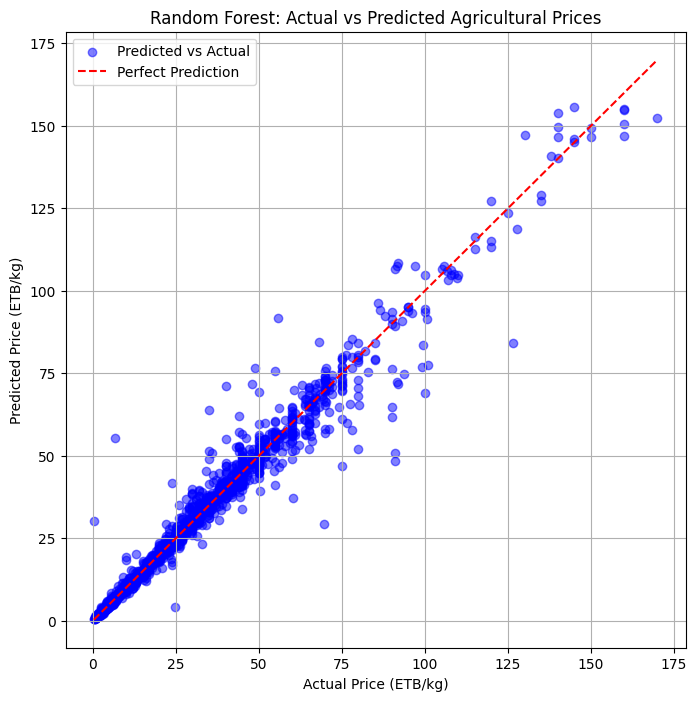

In [38]:
plt.figure(figsize=(8,8)) # Set figure size for better readability
plt.scatter(y_test, rf_preds, alpha=0.5, color='blue', label='Predicted vs Actual') # Create scatter plot of actual vs. predicted prices

# Add a 'perfect prediction' line (y=x)
min_val = min(y_test.min(), rf_preds.min()) # Determine the minimum value across actual and predicted prices
max_val = max(y_test.max(), rf_preds.max()) # Determine the maximum value across actual and predicted prices
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Prediction') # Plot the 'perfect prediction' line

plt.xlabel("Actual Price (ETB/kg)") # Label the x-axis
plt.ylabel("Predicted Price (ETB/kg)") # Label the y-axis
plt.title("Random Forest: Actual vs Predicted Agricultural Prices") # Set the plot title
plt.legend() # Display legend
plt.grid(True) # Add grid for better readability
plt.show() # Display the plot

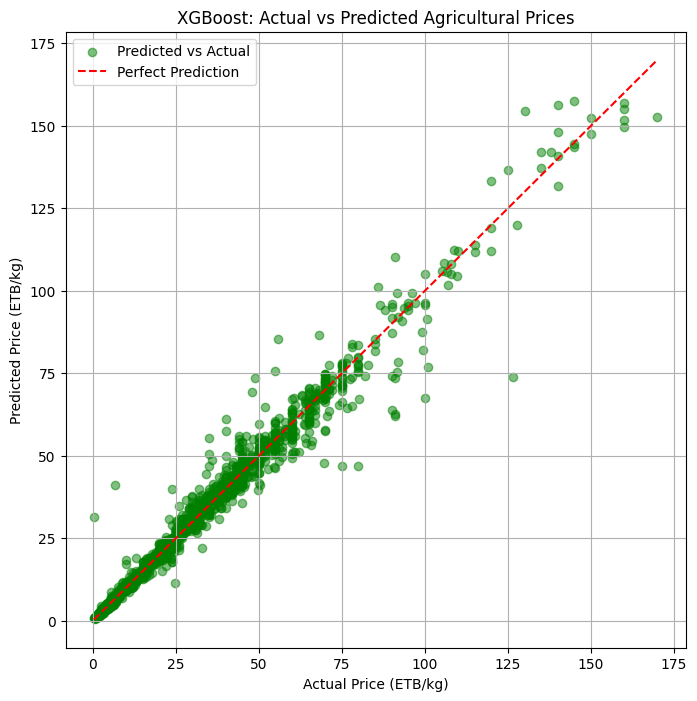

In [39]:
plt.figure(figsize=(8,8)) # Set a larger figure size for better visualization
plt.scatter(y_test, xgb_preds, alpha=0.5, color='green', label='Predicted vs Actual') # Create scatter plot of actual vs. predicted prices

# Add a 'perfect prediction' line (y=x)
min_val_xgb = min(y_test.min(), xgb_preds.min()) # Determine the minimum value across actual and predicted prices
max_val_xgb = max(y_test.max(), xgb_preds.max()) # Determine the maximum value across actual and predicted prices
plt.plot([min_val_xgb, max_val_xgb], [min_val_xgb, max_val_xgb], 'r--', label='Perfect Prediction') # Plot the 'perfect prediction' line

plt.xlabel("Actual Price (ETB/kg)") # Label the x-axis
plt.ylabel("Predicted Price (ETB/kg)") # Label the y-axis
plt.title("XGBoost: Actual vs Predicted Agricultural Prices") # Set the plot title
plt.legend() # Display legend
plt.grid(True) # Add grid for better readability
plt.show() # Display the plot

In [40]:
rf_mae = mean_absolute_error(y_test, rf_preds)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_preds))
rf_r2 = r2_score(y_test, rf_preds)

xgb_mae = mean_absolute_error(y_test, xgb_preds)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_preds))
xgb_r2 = r2_score(y_test, xgb_preds)

metrics_data = {
    'Model': ['Random Forest', 'XGBoost'],
    'MAE': [rf_mae, xgb_mae],
    'RMSE': [rf_rmse, xgb_rmse],
    'R2 Score': [rf_r2, xgb_r2]
}

metrics_df = pd.DataFrame(metrics_data)
print("Metrics DataFrame created:")
print(metrics_df)

Metrics DataFrame created:
           Model       MAE      RMSE  R2 Score
0  Random Forest  2.005062  4.614377  0.970333
1        XGBoost  1.861166  4.087365  0.976722


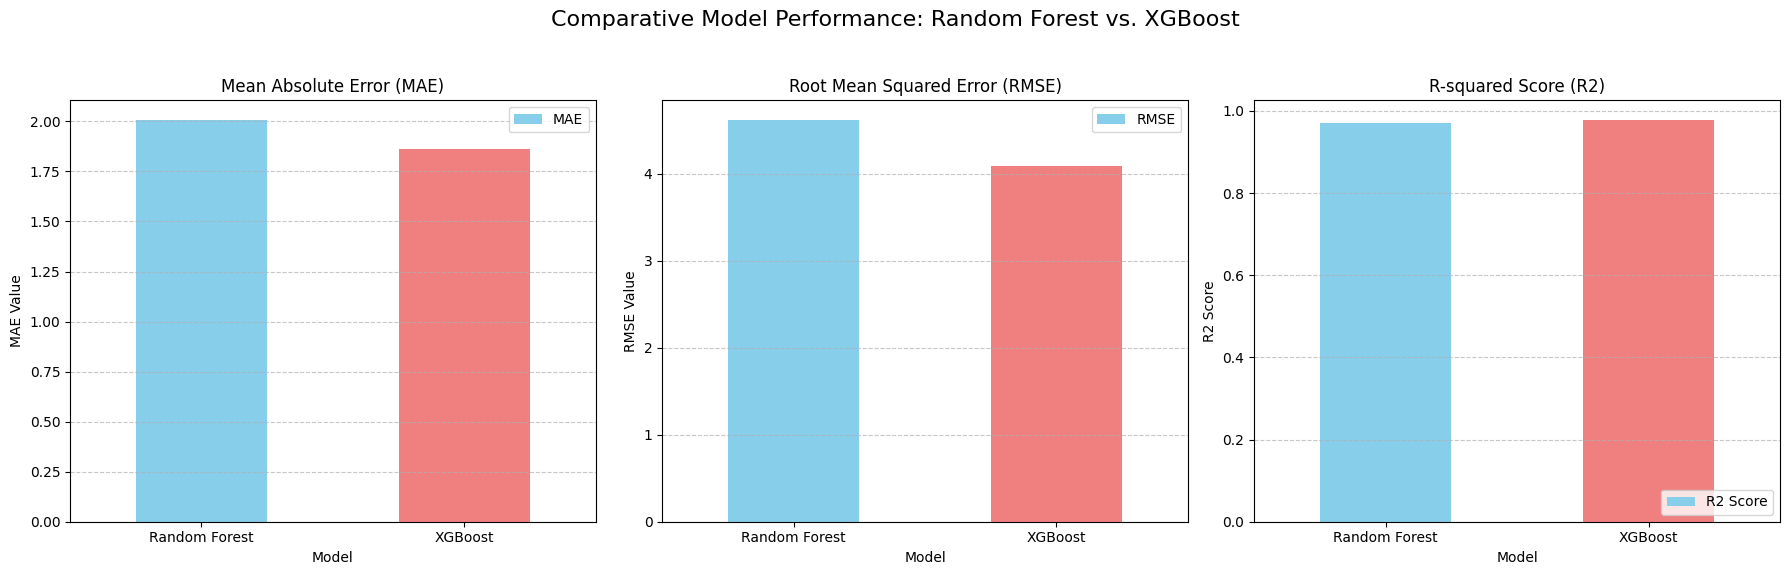

In [41]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6)) # Create a figure with 3 subplots for MAE, RMSE, and R2

# Plot MAE
metrics_df.plot(x='Model', y='MAE', kind='bar', ax=ax[0], rot=0, color=['skyblue', 'lightcoral'])
ax[0].set_title('Mean Absolute Error (MAE)')
ax[0].set_ylabel('MAE Value')
ax[0].legend(loc='upper right')
ax[0].grid(axis='y', linestyle='--', alpha=0.7)

# Plot RMSE
metrics_df.plot(x='Model', y='RMSE', kind='bar', ax=ax[1], rot=0, color=['skyblue', 'lightcoral'])
ax[1].set_title('Root Mean Squared Error (RMSE)')
ax[1].set_ylabel('RMSE Value')
ax[1].legend(loc='upper right')
ax[1].grid(axis='y', linestyle='--', alpha=0.7)

# Plot R2 Score
metrics_df.plot(x='Model', y='R2 Score', kind='bar', ax=ax[2], rot=0, color=['skyblue', 'lightcoral'])
ax[2].set_title('R-squared Score (R2)')
ax[2].set_ylabel('R2 Score')
ax[2].legend(loc='lower right')
ax[2].grid(axis='y', linestyle='--', alpha=0.7)

plt.suptitle('Comparative Model Performance: Random Forest vs. XGBoost', fontsize=16) # Set a main title for the entire figure
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
plt.show() # Display the plots

In [42]:
cat /content/logs.txt

Usage: streamlit run [OPTIONS] [TARGET] [ARGS]...
Try 'streamlit run --help' for help.

Error: Invalid value: File does not exist: app.py


In [43]:
from pyngrok import ngrok

ngrok.set_auth_token("36wQfewIxvInBKrAGD7cRPvyxQM_7Wh1iN5p5Ch4QVkFP1HiW")

!streamlit run /content/drive/MyDrive/Colab/agriculture_project/App/app.py &>/content/logs.txt &
public_url = ngrok.connect(8501)
public_url

<NgrokTunnel: "https://unpopular-pattie-hesitatingly.ngrok-free.dev" -> "http://localhost:8501">

In [44]:
app_file_path = "/content/drive/MyDrive/Colab/agriculture_project/App/app.py"
!cat "{app_file_path}"

import streamlit as st
import pandas as pd
import joblib
import numpy as np
import matplotlib.pyplot as plt
import calendar

# Load model and features
#model = joblib.load("price_prediction_model.pkl")
#features = joblib.load("model_features.pkl")

model = joblib.load("/content/drive/MyDrive/Colab/agriculture_project/Model/price_model.pkl")
features = joblib.load("/content/drive/MyDrive/Colab/agriculture_project/Model/model_features.pkl")

st.set_page_config(
    page_title="Ethiopian Agricultural Price Predictor",
    layout="wide"
)

# ---------------- HEADER ----------------
st.title("🌾 Ethiopian Agricultural Price Prediction System")
st.markdown(
    "Predict **next month agricultural commodity prices** in Ethiopian markets using machine learning."
)
st.divider()

# ---------------- INPUTS ----------------
st.subheader("📥 Prediction Inputs")

col1, col2, col3 = st.columns(3)

with col1:
    commodity = st.selectbox(
        "Commodity",
        ["Teff (white)", "Wheat (white)", "Ma

In [45]:
app_file_path = "/content/drive/MyDrive/Colab/agriculture_project/App/app.py"
!streamlit run "{app_file_path}"




  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8502
  Network URL: http://172.28.0.12:8502
  External URL: http://136.111.200.19:8502



  Stopping...
  Stopping...


## Explain Random Forest

### Subtask:
Provide a detailed explanation of the Random Forest algorithm, including its ensemble nature, bootstrap aggregating (bagging), feature randomness, and key characteristics.

### Explanation of Random Forest:

Random Forest is a powerful and versatile supervised machine learning algorithm that is widely used for both classification and regression tasks. It is an **ensemble learning method** that operates by constructing a multitude of decision trees during training and outputting the mode of the classes (for classification) or mean prediction (for regression) of the individual trees. The core idea behind Random Forest is that a large number of relatively uncorrelated models (decision trees) operating as a committee will outperform any individual constituent model.

1.  **Ensemble Nature**: Random Forest is built upon the principle of ensemble learning, where multiple models are combined to solve a particular computational intelligence problem. Specifically, it employs the **'forest'** of trees as its fundamental structure. Each tree in the forest is trained independently, and their individual predictions are aggregated to produce a final, more robust prediction. This ensemble approach helps to reduce overfitting and improve the generalization ability of the model compared to a single decision tree.

2.  **Bootstrap Aggregating (Bagging)**: A key component of Random Forest is **Bootstrap Aggregating (Bagging)**. This technique involves creating multiple subsets of the original training data through **random sampling with replacement**. For an original dataset of 'N' samples, each bootstrap sample will also contain 'N' samples, where some original samples may appear multiple times and others not at all. Each decision tree in the Random Forest is then trained independently on a different one of these bootstrap samples. This process introduces diversity among the trees, as each tree sees a slightly different version of the training data, leading to less correlated predictions.

3.  **Feature Randomness (Random Subspace Method)**: In addition to bagging samples, Random Forest introduces another layer of randomness: **feature randomness**. At each node split during the construction of a decision tree, instead of considering all available features to find the best split, Random Forest considers only a **random subset of features**. This means that if there are 'M' features in total, at each split, only a randomly selected 'm' features (where m < M) are evaluated. This process further decorrelates the trees, preventing a few very strong features from dominating the splitting logic across all trees. By forcing trees to rely on different feature subsets, the model becomes more robust and less prone to capturing noise in the data.

4.  **Prediction Mechanism**: Once all the decision trees are trained, the Random Forest makes predictions based on the aggregated outputs of these trees:
    *   For **regression tasks**, the final prediction is typically the **average** of the predictions made by all individual decision trees.
    *   For **classification tasks**, the final prediction is determined by **majority voting**, where the class predicted most frequently by the individual trees is chosen as the Random Forest's prediction.

5.  **Key Characteristics and Advantages**:
    *   **Reduced Overfitting**: By averaging or majority voting the predictions of many decorrelated trees, Random Forest significantly reduces the risk of overfitting, which is a common issue with individual decision trees.
    *   **High Accuracy**: It often provides high predictive accuracy, making it a strong contender for various real-world problems.
    *   **Handles High-Dimensional Data**: It can efficiently handle datasets with a large number of features and is robust to multicollinearity.
    *   **Implicit Feature Importance**: Random Forest provides a measure of feature importance, indicating which features contribute most to the prediction. This can be valuable for feature selection and understanding the underlying data.
    *   **Robustness to Outliers and Noise**: The ensemble nature and random sampling make it less sensitive to outliers and noise in the training data.
    *   **Versatility**: Applicable to both classification and regression problems without significant modifications.
    *   **Easy to Use**: It requires minimal parameter tuning compared to some other complex algorithms.